In [ ]:
import kagglehub

path = kagglehub.dataset_download("cashutosh/gender-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gender-classification-dataset


In [ ]:
import os

base_path = "/kaggle/input/gender-classification-dataset"
print(os.listdir(base_path))

['Validation', 'Training']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/kaggle/input/gender-classification-dataset/Training"
val_dir = "/kaggle/input/gender-classification-dataset/Validation"

train_gen = ImageDataGenerator(
    rescale=1./255,                # Normalisasi pixel (0-255 jadi 0-1)
    validation_split=0.2,          # Split 20% untuk validasi
    rotation_range=40,            # Augmentasi rotasi
    width_shift_range=0.2,        # Pergeseran horizontal
    height_shift_range=0.2,       # Pergeseran vertikal
    shear_range=0.2,              # Transformasi shearing
    zoom_range=0.2,               # Zoom in/out
    horizontal_flip=True          # Flip horizontal
)

test_gen = ImageDataGenerator(rescale=1./255)  # Untuk data test hanya normalisasi


In [ ]:

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=512,
    class_mode="binary",
    subset="training"
)

val_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=512,
    class_mode="binary",
    subset="validation"
)

test_generator = test_gen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=512,
    class_mode="binary",
    shuffle=False
)



Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [ ]:
train_generator.class_indices #labelling

{'female': 0, 'male': 1}

In [ ]:
img, label = next(train_generator) #Mengambil satu batch gambar dan label dari generator
#Batch gambar dalam format array (batch_size, height, width, channels)

##Visualisasi

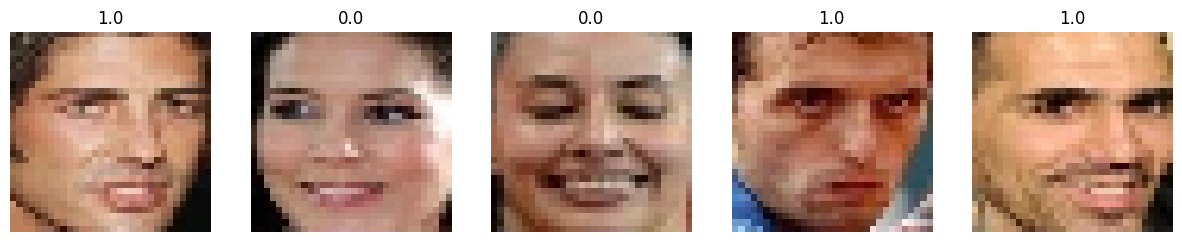

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 5, figsize=(15,5))
for i in range(5):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(label[i])
plt.show() #menampilkan 5 gambar pertama dari batch

##Modelling dengan CNN

In [ ]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2

!pip install keras-tuner -q
from kerastuner.tuners import RandomSearch

from keras.models import load_model

<ipython-input-8-7fb3539fa432>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:

def build_model(hp):

    model = Sequential()

    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                     activation='relu',
                     input_shape=(32, 32, 3),
                     kernel_regularizer = l1_l2(0.0001, 0.0001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('conv_layers', 1, 3)):
      model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
                      kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                      activation='relu',
                      kernel_regularizer = l1_l2(0.0001, 0.0001)))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
      model.add(Dropout(0.25))



    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=64, max_value=128, step=32),
                   activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='project',
    project_name='Gender_Classification'
)

tuner.search(train_generator, epochs=30, validation_data=val_generator)

tuner.results_summary()

best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best parameters: \n", best_params.values)
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 49m 24s]
val_accuracy: 0.9506435394287109

Best val_accuracy So Far: 0.9627699255943298
Total elapsed time: 03h 01m 48s
Results summary
Results in project/Gender_Classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 5
conv_layers: 1
conv_2_filter: 64
conv_2_kernel: 5
dense_1_units: 128
learning_rate: 0.001
Score: 0.9627699255943298

Trial 3 summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
conv_layers: 1
conv_2_filter: 64
conv_2_kernel: 3
dense_1_units: 96
learning_rate: 0.001
Score: 0.9612807035446167

Trial 4 summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
conv_layers: 2
conv_2_filter: 16
conv_2_kernel: 3
dense_1_units: 64
learning_rate: 0.001
Score: 0.9506435394287109

Trial 0 summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 3
conv_layers: 3
conv_2_filter: 32
conv_2_kernel: 5
dense_1_units: 128
learning_rate: 0.001
Traceback (most r

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(32, 32, 3),
                     kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64,
                      kernel_size=(3, 3),
                      activation='relu',
                      kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,
                      kernel_size=(3, 3),
                      activation='relu',
                      kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(units=128,
                   activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
result = model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6023 - loss: 1.1678 - val_accuracy: 0.5806 - val_loss: 0.9779
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7449 - loss: 0.8371 - val_accuracy: 0.7288 - val_loss: 0.9171
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8126 - loss: 0.7185 - val_accuracy: 0.5986 - val_loss: 0.8741
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8503 - loss: 0.6322 - val_accuracy: 0.8111 - val_loss: 0.7187
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8714 - loss: 0.5801 - val_accuracy: 0.7779 - val_loss: 0.6961
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8876 - loss: 0.5443 - val_accuracy: 0.8748 - val_loss: 0.5591
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9041 - loss: 0.5049 - val_accuracy: 0.8952 - val_loss: 0.5106
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9082 - loss: 0.4941 - val_accuracy: 0.8984 - val_lo

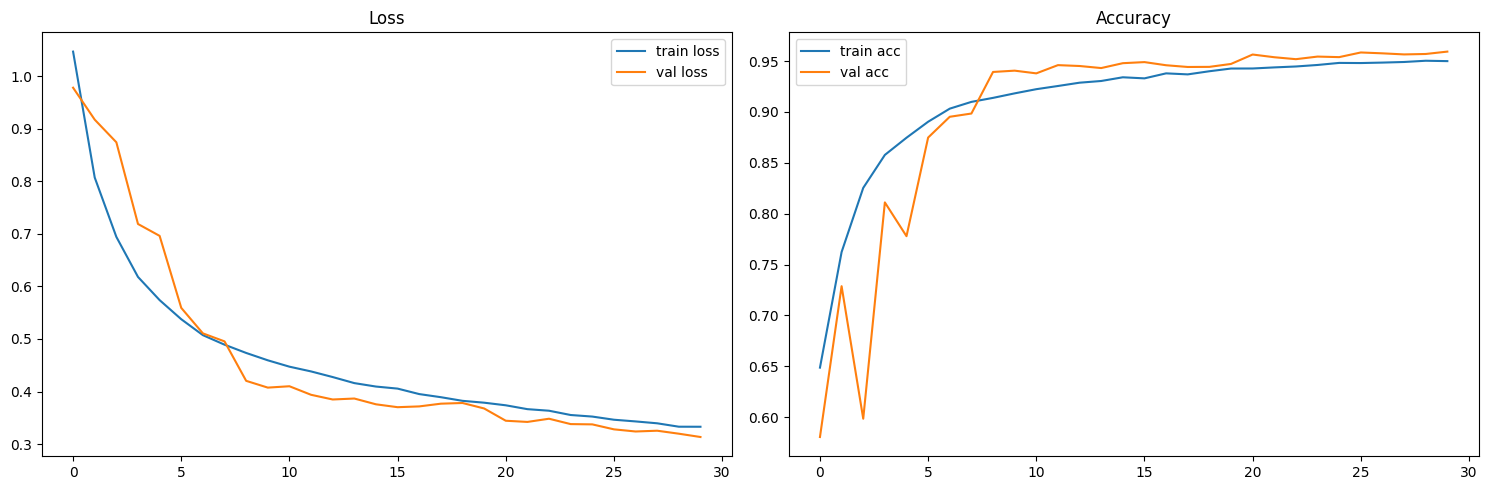

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(result.history['loss'], label='train loss')
ax[0].plot(result.history['val_loss'], label='val loss')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(result.history['accuracy'], label='train acc')
ax[1].plot(result.history['val_accuracy'], label='val acc')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/CNN_model.h5')

In [ ]:
best_model = load_model('/content/CNN_model.h5')

#Result

In [ ]:
loss, accuracy = best_model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9638 - loss: 0.2910
Test Loss: 0.30426791310310364
Test Accuracy: 0.9589664340019226


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 681ms/step


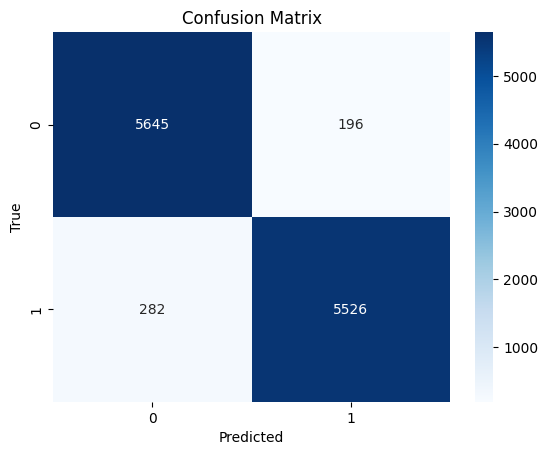

              precision    recall  f1-score   support

      Female       0.95      0.97      0.96      5841
        Male       0.97      0.95      0.96      5808

    accuracy                           0.96     11649
   macro avg       0.96      0.96      0.96     11649
weighted avg       0.96      0.96      0.96     11649



In [ ]:
import seaborn as sns

y_true = test_generator.labels
y_pred = (best_model.predict(test_generator) > 0.5).astype("int32").flatten()
"""
sorted_indices = np.argsort(test_generator.filenames)
y_true = y_true[sorted_indices]
y_pred = y_pred[sorted_indices]
"""
# Confusion matrix ve classification report
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_true, y_pred, target_names=["Female","Male"]))

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing import image

def predict_and_show_images(model, test_generator, num_images=5):
    plt.figure(figsize=(25, 25))
    for i in range(num_images):
        # Choose a random image
        img_path = test_generator.filepaths[random.randint(0, len(test_generator.filepaths) - 1)]
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        # Make the prediction
        prediction = model.predict(img_array)
        pred_label = 'Male' if prediction[0][0] > 0.5 else 'Female'
        # Display the image with the prediction
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.load_img(img_path))
        plt.title(f"Prediction: {pred_label}")
        plt.axis("off")
    plt.show()

def predict_any_image(model, image_path):
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    pred_label = 'Male' if prediction[0][0] > 0.5 else 'Female'
    plt.imshow(img)
    plt.title(f"Prediction: {pred_label}, Confidence: {prediction[0][0]: .2f}")
    plt.axis("off")
    plt.show()

In [ ]:
# prompt: predict any image from url

def predict_image_from_url(model, image_url):
    import requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    import numpy as np

    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        image = Image.open(BytesIO(response.content))
        image = image.resize((32, 32))  # Resize the image
        img_array = image.img_to_array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        pred_label = 'Male' if prediction[0][0] > 0.5 else 'Female'

        plt.imshow(image)
        plt.title(f"Prediction: {pred_label}, Confidence: {prediction[0][0]:.2f}")
        plt.axis("off")
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error processing image: {e}")

In [ ]:
def predict_image_from_url(model, image_url):
    import requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    import numpy as np

    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        image = Image.open(BytesIO(response.content))
        image = image.resize((32, 32))  # Resize the image
        img_array = np.array(image) / 255.0  # Changed from image.img_to_array to np.array
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        pred_label = 'Male' if prediction[0][0] > 0.5 else 'Female'
        confidence = prediction[0][0] if pred_label == 'Male' else 1 - prediction[0][0]

        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(pred_label, color='red')
        plt.axis("off")
        plt.show()

        print(f"\nPrediction: {pred_label}")
        print(f"Confidence: {confidence:.2f}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error processing image: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


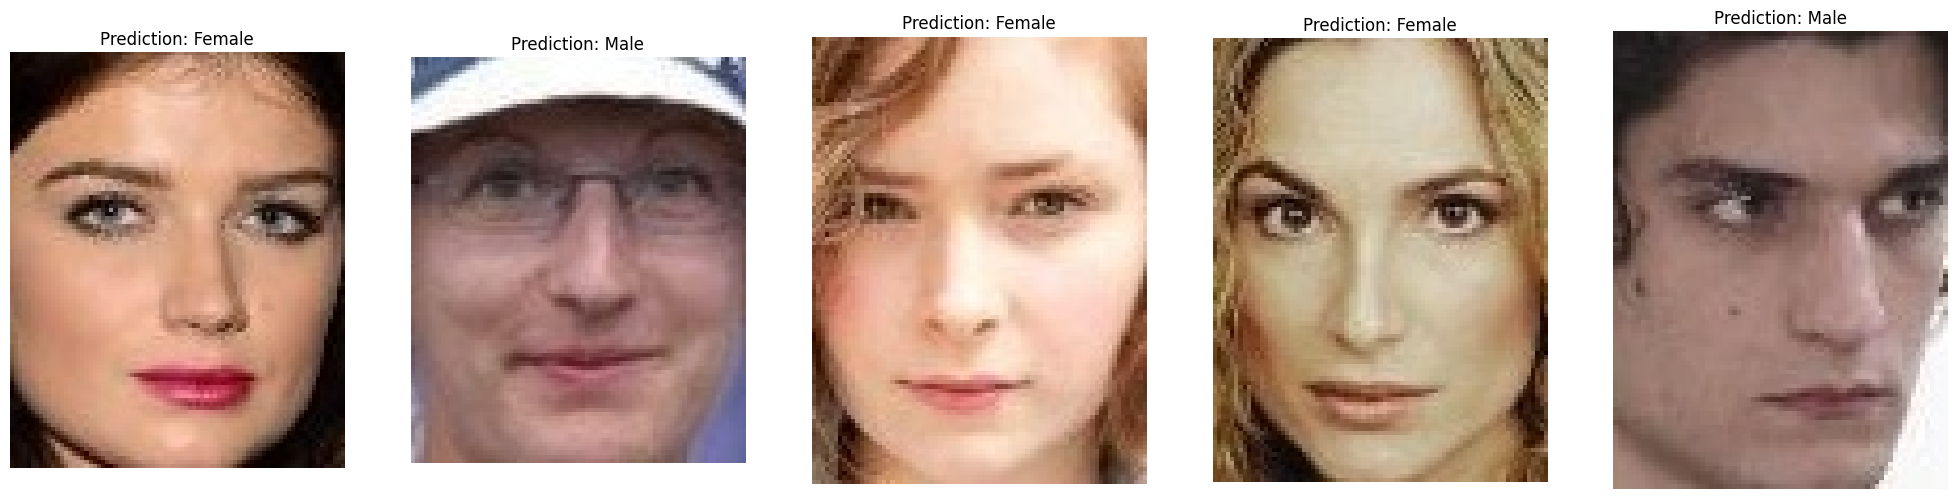

In [ ]:
predict_and_show_images(best_model, test_generator)
